In [38]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

## Bayesian Statistics for Demand Forecasting

A very, very, simple problem and approach but shows the intuitiveness of priors, simulations, and parameters modeled as random variables

In [5]:
def profit_function(inventory, demand, wholesale=5, list_price=7):
    # Profit = R(x) - C(x)
    return list_price * np.min([inventory, demand]) - wholesale * inventory

In [6]:
def profit_calculator(inventory, demand, wholesale=5, list_price=7):
    profit = list_price - wholesale
    if demand < inventory:
        overstock = inventory - demand
        utility = demand * profit - wholesale * overstock
    elif demand >= inventory:
        utility = inventory * profit
    else:
        # We want demand and inventory to equal each other
        utility = inventory * profit
    return utility

### Variable Demand

Indeed, demand is never fixed, it is subject to variability (mean and standard deviation), and thus can be represented with a continuous distribution

_Goal_: How many newspapers to buy when demand fluctuates?

In [13]:
np.random.seed(seed=42)
# Random normally distribued values over "15 days" with average demand of 40 with a standard devation of 20
demand = stats.norm(40, 20).rvs(15)
# Given the demand seen, how we make informed choices for the demand we have not seen?
observed_data, unobserved_data = demand[:5], demand[5:]


### Bayesian Statistics - Addressing Uncertainty

We only have 5 data points for our observed demand data; therefore we should simulate more data


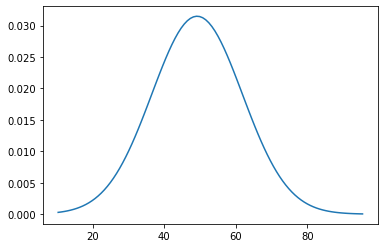

In [32]:
# Demand Distribution Curve
x = np.linspace(np.min(observed_data) - 25, np.max(observed_data) + 25, 100)
y = stats.norm(np.mean(observed_data), np.std(observed_data)).pdf(x)
plt.plot(x, y)
plt.show()

Text(0, 0.5, 'Estimate of std')

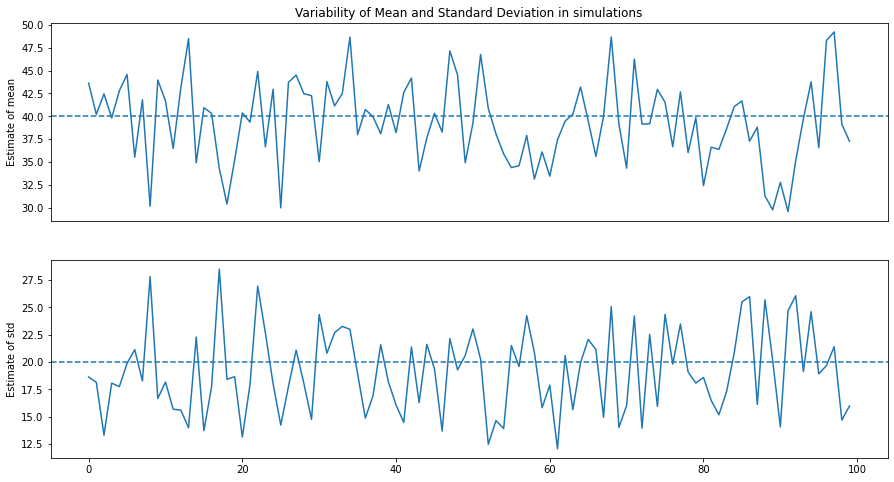

In [37]:
# With such a small sample, we should simulate more data
sims = 100
mean, std = [], []

for _ in range(sims):
    true_mean, true_std = 40, 20
    values = stats.norm(40, 20).rvs(15)
    mean.append(values.mean())
    std.append(values.std())

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].plot(range(sims), mean)
ax[0].set_xticks([])
ax[0].axhline(40, 0, 1, linestyle='--')
ax[0].set_ylabel('Estimate of mean')
ax[0].set_title('Variability of Mean and Standard Deviation in simulations')

ax[1].plot(range(sims), std)
ax[1].axhline(20, 0, 1, linestyle='--')
ax[1].set_ylabel('Estimate of std')

In [39]:
with pm.Model() as vendor:

    # Priors
    sd = pm.HalfStudentT('demand_std', sigma=10, nu=20)
    mu = pm.Normal('Demand_mu', observed_data.mean(), 20)
    demand = pm.TruncatedNormal('demand', mu=mu, sd=sd, lower=0, observed=observed_data)

    trace = pm.sample(tune=5000, draws=10000, chains=2)
    posterior_predictive = pm.sample_posterior_predictive(trace, progressbar=False)
    # Inference data - posterior
    inf_data = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also 

Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 38 seconds.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.t

array([<AxesSubplot:title={'center':'Demand_mu'}>,
       <AxesSubplot:title={'center':'demand_std'}>], dtype=object)

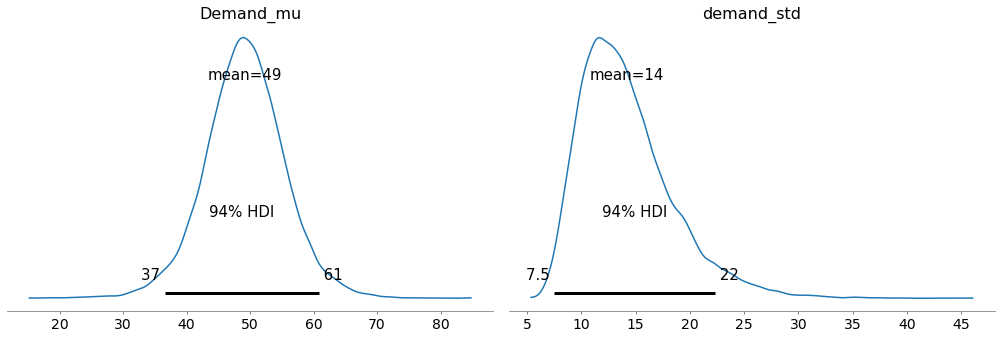

In [40]:
az.plot_posterior(inf_data)

Text(0.5, 1.0, 'Half Student-t Distribution of std of demand')

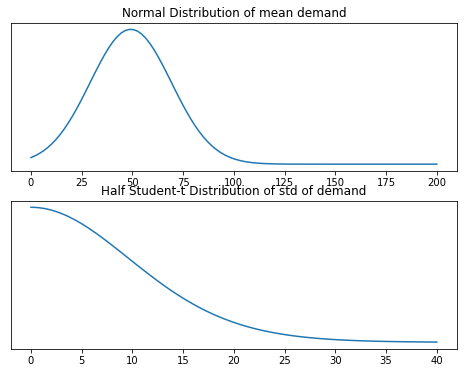

In [47]:
# Plotting prior distributions - mu & std
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Mu
x = np.linspace(0, 200, 100)
y = stats.norm(observed_data.mean(), 20).pdf(x)

ax[0].plot(x, y)
ax[0].set_yticks([])
ax[0].set_title('Normal Distribution of mean demand')

# Sigma
x = np.linspace(0, 40, 100)
y = stats.t.pdf(x, df=20, loc=0, scale=10)

ax[1].plot(x, y)
ax[1].set_yticks([])
ax[1].set_title('Half Student-t Distribution of std of demand')

### Posterior Distribution - Future Demand

Posterior predictive 

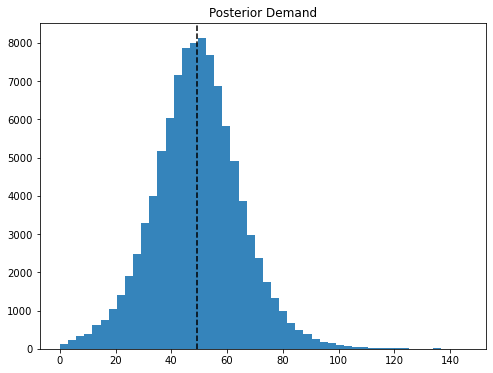

In [69]:
future_demand = inf_data.posterior_predictive['demand'].values.flatten()

plt.figure(figsize=(8, 6))
plt.hist(future_demand, bins=50, alpha=0.9)
plt.axvline(future_demand.mean(), linestyle='--', color='black')
plt.title('Posterior Demand')
plt.show()
